In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles  # Dataset sintético alternativo
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [15]:
# --- Carga de Datos ---
# Opción 1: Dataset sintético (make_circles)
X, _ = make_circles(n_samples=1000, factor=0.5, noise=0.05, random_state=42)

# Opción 2: Carga tu propio dataset sin etiquetas (descomenta y ajusta la ruta)
# X = np.loadtxt('ruta/a/tu/dataset.csv', delimiter=',')  # Ejemplo para CSV
# Asegúrate de que tu dataset sea un array 2D con shape (n_samples, n_features)


In [16]:
# --- Funciones Auxiliares ---
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

def plot_centroids(means, weights=None):
    if weights is not None:
        for i, (mean, weight) in enumerate(zip(means, weights)):
            plt.scatter(mean[0], mean[1], s=500 * weight, marker='*', color='black', zorder=10)
    else:
        plt.scatter(means[:, 0], means[:, 1], s=200, marker='*', color='black', zorder=10)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="Paired", alpha=0.2)
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    if show_centroids:
        plot_centroids(clusterer.means_, clusterer.weights_ if hasattr(clusterer, 'weights_') else None)
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Clústeres DBSCAN (eps=0.05): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Clústeres DBSCAN (eps=0.2): [0 1]


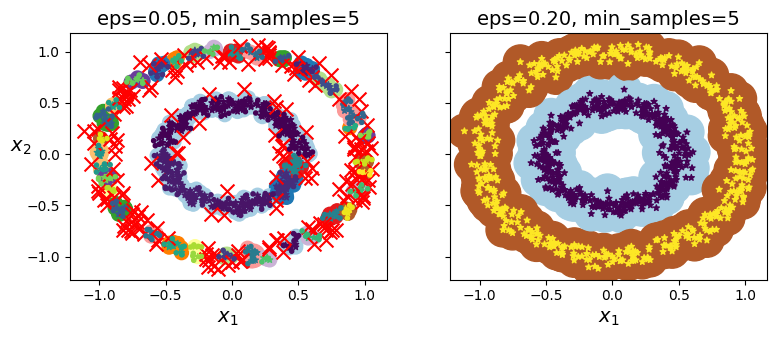

Predicciones KNN: [0 0 1 1]
Probabilidades KNN: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


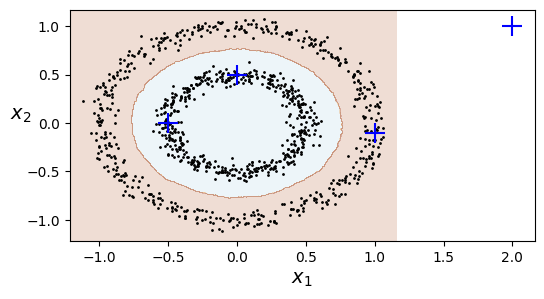

In [17]:
# --- DBSCAN ---
# Modelo 1: eps pequeño
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
print("Clústeres DBSCAN (eps=0.05):", np.unique(dbscan.labels_))

# Modelo 2: eps más grande
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)
print("Clústeres DBSCAN (eps=0.2):", np.unique(dbscan2.labels_))

# Visualización DBSCAN
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)
plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)
plt.show()

# --- KNeighbors para predicción ---
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

# Nuevos puntos para predicción
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print("Predicciones KNN:", knn.predict(X_new))
print("Probabilidades KNN:", knn.predict_proba(X_new))

# Visualización de fronteras de decisión
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()


D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\Miniconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\cluster\_kmeans.p

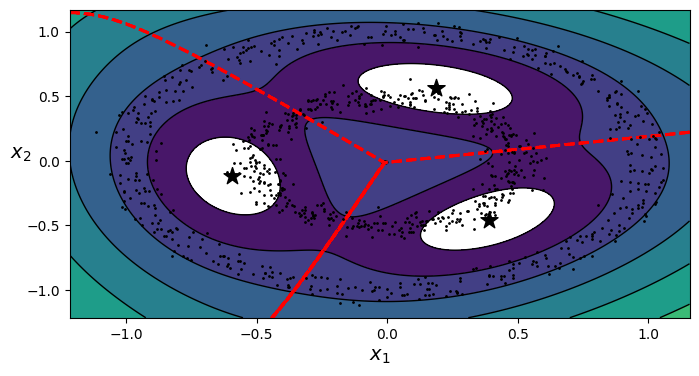

Pesos GM: [0.32688874 0.34015114 0.33296012]
Medias GM: [[-0.59308964 -0.12052055]
 [ 0.1869011   0.56122463]
 [ 0.38909456 -0.45904683]]
Covarianzas GM: [[[ 0.07158611 -0.02419608]
  [-0.02419608  0.18956388]]

 [[ 0.18616596 -0.04117059]
  [-0.04117059  0.08507214]]

 [[ 0.1428336   0.0652838 ]
  [ 0.0652838   0.12534345]]]
Probabilidades GM: [[2.83001843e-04 7.24616564e-01 2.75100434e-01]
 [9.44727500e-01 5.42113074e-02 1.06119298e-03]
 [9.50764054e-01 4.90595607e-02 1.76385444e-04]
 ...
 [2.31838613e-01 2.48604351e-04 7.67912782e-01]
 [5.60540745e-05 7.34509406e-05 9.99870495e-01]
 [8.68491634e-05 9.99877732e-01 3.54188893e-05]]
Nuevas muestras GM: [[-0.26205581  0.23574982]
 [-0.63250565 -0.23349906]
 [-0.27435029 -0.77319962]
 [ 0.45376912 -0.21415683]
 [ 0.62515071 -0.41413951]
 [ 0.63674009 -0.90638684]]
Etiquetas de nuevas muestras: [0 0 2 2 2 2]


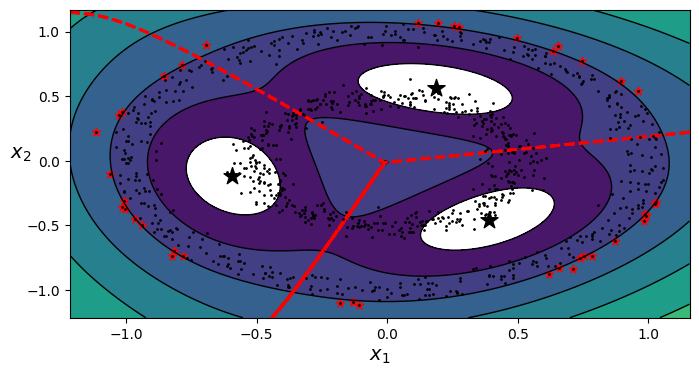

In [22]:
# Gaussian Mixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

# Visualización
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

# Propiedades del modelo
print("Pesos GM:", gm.weights_)
print("Medias GM:", gm.means_)
print("Covarianzas GM:", gm.covariances_)  
#print("Predicciones GM:", gm.predict(X))
print("Probabilidades GM:", gm.predict_proba(X))

# Generar nuevas muestras
X_new, y_new = gm.sample(6)
print("Nuevas muestras GM:", X_new)
print("Etiquetas de nuevas muestras:", y_new)

# Detección de anomalías
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=X.max(axis=0)[1] + 0.1)
plt.show()